In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,Occupancy,Hour,Minute
0,21.76,31.13333,1,14,48
1,21.79,31.00000,1,14,49
2,21.77,31.12250,1,14,50
3,21.77,31.12250,1,14,51
4,21.79,31.13333,1,14,51


In [4]:
df_train.shape

(9752, 5)

In [5]:
df_train.duplicated().sum()
df_train = df_train.drop_duplicates(ignore_index=True)

In [6]:
df_val.duplicated().sum()
df_val = df_val.drop_duplicates(ignore_index=True)

In [7]:
df_test.duplicated().sum()
df_test = df_test.drop_duplicates(ignore_index=True)

In [8]:
df_val.shape

(2526, 5)

In [9]:
df_test.shape


(7625, 5)

In [10]:
# Splitting into X and y
X_train = df_train.drop('Occupancy', axis=1).values
y_train = df_train['Occupancy'].values
X_val = df_val.drop('Occupancy', axis=1).values
y_val = df_val['Occupancy'].values
X_test = df_test.drop('Occupancy', axis=1).values
y_test = df_test['Occupancy'].values

 # Column index for minute and hour
time_columns = [2, 3]
# First and second columns are continuous
continuous_columns = [0, 1]

# Scaling oonly first two columns
scaler = StandardScaler()
X_train[:, continuous_columns] = scaler.fit_transform(X_train[:, continuous_columns])
X_test[:, continuous_columns]  = scaler.transform(X_test[:, continuous_columns])
X_val[:, continuous_columns]  = scaler.transform(X_val[:, continuous_columns])

time_scaler = MinMaxScaler()
X_train[:, time_columns] = time_scaler.fit_transform(X_train[:, time_columns])
X_test[:, time_columns]  = time_scaler.transform(X_test[:, time_columns])
X_val[:, time_columns]  = time_scaler.transform(X_val[:, time_columns])
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (9249, 4) (2526, 4) (7625, 4)


In [11]:
# Let's see some values
print("After Scaling :\n", X_train[:3], "\nLabels:", y_train[:3])

After Scaling :
 [[0.72887849 0.32646912 0.60869565 0.81355932]
 [0.7582453  0.2927464  0.60869565 0.83050847]
 [0.73866743 0.32372993 0.60869565 0.84745763]] 
Labels: [1 1 1]


In [12]:
# MAKING SEQUENCES:

window_size = 60
# I need to create a function for making windows
def time_windows(X, y, window_size, step_ahead = 1):
    # Creating two list for features and labels
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size - step_ahead + 1):
        X_windows.append(X[i:i+window_size])
        # so the next step after the window must be predicted
        # if window_size from 0 to 30, the next step is 30
        y_windows.append(y[i+window_size-1 + step_ahead])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = time_windows(X_train, y_train, window_size)
X_val, y_val = time_windows(X_val, y_val, window_size)
X_test, y_test = time_windows(X_test, y_test, window_size)

print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)
print('Example  X:', X_train[0])
print("Example  y:", y_train[0])

Training sequences shape: (9189, 60, 4)
Training class shape: (9189,)
Example  X: [[0.72887849 0.32646912 0.60869565 0.81355932]
 [0.7582453  0.2927464  0.60869565 0.83050847]
 [0.73866743 0.32372993 0.60869565 0.84745763]
 [0.73866743 0.32372993 0.60869565 0.86440678]
 [0.7582453  0.32646912 0.60869565 0.86440678]
 [0.72887849 0.35850735 0.60869565 0.89830508]
 [0.7582453  0.34269943 0.60869565 0.91525424]
 [0.7582453  0.39223007 0.60869565 0.93220339]
 [0.7582453  0.37305064 0.60869565 0.93220339]
 [0.7582453  0.40993495 0.60869565 0.96610169]
 [0.7582453  0.42553294 0.60869565 0.96610169]
 [0.7582453  0.43817927 0.60869565 0.98305085]
 [0.7582453  0.39265246 0.65217391 0.        ]
 [0.7582453  0.39202014 0.65217391 0.01694915]
 [0.7582453  0.41920977 0.65217391 0.03389831]
 [0.78761212 0.41920977 0.65217391 0.05084746]
 [0.78761212 0.41225428 0.65217391 0.06779661]
 [0.85613469 0.44450244 0.65217391 0.06779661]
 [0.7582453  0.43185611 0.65217391 0.10169492]
 [0.78761212 0.47738292 0

In [13]:
zero_count = (y_train == 0).sum()
one_count = (y_train == 1).sum()
one_weight = torch.tensor([zero_count / max(one_count, 1)], dtype=torch.float32).to(device)
print("1 class weight:", one_weight)

1 class weight: tensor([3.7075])


In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long) 
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test= torch.tensor(X_test, dtype=torch.float32)
y_test= torch.tensor(y_test, dtype=torch.long)

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class OccupancyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.fc1   = nn.Linear(32 * 15, 64)  
        self.fc2   = nn.Linear(64, 1)
        self.drop_conv = nn.Dropout(p=0.5)  
        self.drop_fc   = nn.Dropout(p=0.5) 

    def forward(self, x):
        #x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop_conv(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop_conv(x)

        x = torch.flatten(x, start_dim=1)  
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)       
        return x
model = OccupancyCNN().to(device)
model

OccupancyCNN(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (drop_conv): Dropout(p=0.5, inplace=False)
  (drop_fc): Dropout(p=0.5, inplace=False)
)

In [16]:
criterion = nn.BCEWithLogitsLoss(pos_weight=one_weight)
print('Loss function:', criterion)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.000005)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
print('Loss function:', criterion)
print('Optimizer:', optimizer)

Loss function: BCEWithLogitsLoss()
Loss function: BCEWithLogitsLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 5e-06
)


In [17]:
epochs = 50
best_val_loss = float('inf')
patience = 7
patience_counter = 0

for epoch in range(1, epochs+1):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float() 
        correct += (preds.squeeze() == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    


 
    model.eval()  
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits.squeeze(1), y_batch.float())
            val_loss += loss.item() * X_batch.size(0)


            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs >= 0.5).to(torch.int64)


            val_preds.extend(preds)
            val_targets.extend(y_batch)
    val_loss = val_loss / len(val_dataset)


    
    # Convert predictions and targets to numpy for calculations
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    val_acc = accuracy_score(val_targets, val_preds)
    val_prec = precision_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    val_rec = recall_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    val_f1 = f1_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    learning_rate = optimizer.param_groups[0]['lr']
    
    # Print metrics for this epoch
    print(f"Epoch {epoch:2d}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}, "
          f"Prec: {val_prec:.3f}, Rec: {val_rec:.3f}, F1: {val_f1:.3f} - "
          f"Learning Rate: {learning_rate:.6f}")
    scheduler.step(val_loss)
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
if patience_counter >= patience:
    model.load_state_dict(best_model_state)


RuntimeError: Given groups=1, weight of size [16, 4, 3], expected input[128, 60, 4] to have 4 channels, but got 60 channels instead

In [ ]:
# Evaluate on test set
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = criterion(logits.squeeze(1), y_batch.float())
        probs = torch.sigmoid(logits.squeeze(1))
        preds = (probs >= 0.5).to(torch.int64)
        val_loss += loss.item() * X_batch.size(0)

        test_preds.extend(preds)
        test_targets.extend(y_batch)
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

Confusion Matrix:


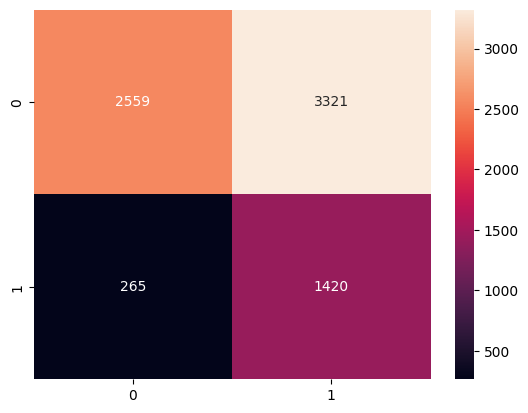

In [ ]:
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [ ]:
Classification_report = classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'], zero_division=0)
print("Classification Report:\n", Classification_report)

Classification Report:
               precision    recall  f1-score   support

No Occupancy       0.91      0.44      0.59      5880
   Occupancy       0.30      0.84      0.44      1685

    accuracy                           0.53      7565
   macro avg       0.60      0.64      0.51      7565
weighted avg       0.77      0.53      0.56      7565

